# *WIP:* Using the vtkInterface Package

This notebook is a work in progress to demo how PVGeo can be used with `vtki` for creating integrated visualizations directly in a Python environment. At this time, the 3D rendering is perfromed in a separate window and we have yet to embed the VTK rendering windowinf into some sort of Jupyter widget.

Maybe someone reading this knows how to embed the rendering window into a widget?!?? If so, join us on [slack](http://slack.pvgeo.org) and let's collaborate!

**DISCLAIMER:** This currently only works on versions `0.13.x` and above of `vtki` and `PVGeo>=1.1.41`

```sh
pip install vtki>=0.13.1
```

**Note:** You can have interactive 3D renderings by specifying `notebook=False` in the plotting routine. This will open a seprate window with the rendering.

## Overview

The goal set forth for this notebook is to use a comination of Python packages to create an integrated visualization of some data and models for a specific project. These packages and their tasks are:

- `discretize` for some file IO,
- `SimPEG` inversion results for an inverted model
- `PVGeo` for its post processing filters and data integration algorithms
- `vtki` to create the 3D renderings of the whole data scene


In [1]:
import vtki
import PVGeo
import numpy as np
import discretize

In [2]:
# Import some specific algorithms from PVGeo that we'd like to use
from PVGeo.grids import ExtractTopography
from PVGeo.ubc import TopoReader
from PVGeo.filters import PercentThreshold, ManySlicesAlongAxis

In [3]:
# This sets the plotting theme of `vtki` to look just like a ParaView rendering
vtki.set_plot_theme('paraview')

## Load the Data

Here we load in some data we'd like to process: the [**Laguna del Maule Bouguer Gravity**](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example from the SimPEG docs.

This data scene is was produced from the [Laguna del Maule Bouguer Gravity](http://docs.simpeg.xyz/content/examples/04-grav/plot_laguna_del_maule_inversion.html#sphx-glr-content-examples-04-grav-plot-laguna-del-maule-inversion-py) example provided by [Craig Miller](https://github.com/craigmillernz) (Maule volcanic field, Chile. Refer to Miller et al 2016 EPSL for full details.)

> Miller, C. A., Williams-Jones, G., Fournier, D., & Witter, J. (2017). 3D gravity inversion and thermodynamic modelling reveal properties of shallow silicic magma reservoir beneath Laguna del Maule, Chile. Earth and Planetary Science Letters, 459, 14–27. https://doi.org/10.1016/j.epsl.2016.11.007

In [4]:
# Load the a TensorMesh and some already processed model data 
mesh = discretize.TensorMesh.readUBC('craig_chile.msh', directory='data/Craig-Chile')
models = {'lpout': mesh.readModelUBC(fileName='Lpout.mod', directory='data/Craig-Chile')}

In [5]:
# Load topography data using PVGeo
topo = TopoReader().Apply('data/Craig-Chile/LdM_topo.topo')
# Note that PVGeo will return a vtki wrapped data object if vtki is available!
topo

(PolyData)0x103c1a948

## Build a Pipeline 

Here we build up a pipeline that will transform and integrate the data

In [6]:
extractor = ExtractTopography(offset=-150, tolerance=10, op='underneath')
extracted = extractor.Apply(mesh.toVTK(models=models), topo)

In [7]:
# threshold out the topography by a simple percent threshold in PVGeo
subsurface = PercentThreshold().Apply(extracted, 'Extracted')
subsurface

(UnstructuredGrid)0x11cb165e8

In [8]:
# Get the scalar range to plot everything the same way
arr = PVGeo.getArray(subsurface, 'lpout')
rng = np.nanmin(arr), np.nanmax(arr)

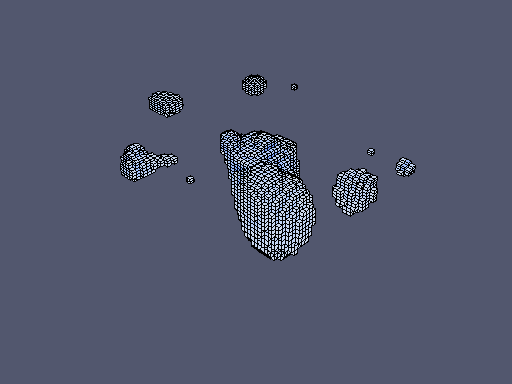

In [9]:
# threshold using vtki on a pecific value
low = subsurface.threshold(-0.2, 'lpout', invert=True)
low.plot(rng=rng, window_size=[1024//2, 768//2])

In [10]:
# Slice the subsurface model
sliced = ManySlicesAlongAxis(numSlices=5, axis=1).Apply(subsurface)
sliced

(MultiBlock)0x11f676528

## Plot in an Interactive 3D Window

In [11]:
# plot a single dataset
sliced.plot(scalars='lpout', notebook=False, )

[(392055.92420956714, 6036055.924209567, 27255.924209567154),
 (363625.0, 6007625.0, -1175.0),
 (0.0, 0.0, 1.0)]

In [12]:
# Or better yet, plot them all in one rendering environment!
p = vtki.Plotter(notebook=False)
#p.add_mesh(extracted, syle='wireframe', opacity=0.25, scalars='lpout', rng=rng)
p.add_bounds_axes(extracted, color='k', fontsize=30)
p.add_mesh(low, scalars='lpout', stitle='lpout', rng=rng)
p.add_mesh(sliced, scalars='lpout', rng=rng)
p.add_mesh(topo, color='white', opacity=0.5, psize=1.0)
p.add_axes()
p.plot(in_background=False)

[(409964.832171196, 6021311.927859372, 11042.360915366977),
 (363625.0, 6007625.0, -1073.0),
 (-0.18804172395380744, -0.2122002377397165, 0.9589636954315257)]